<a href="https://colab.research.google.com/github/ABCutter/DDDS-My-Projects/blob/main/Project-5/Project5_NLP_isitfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing



This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive


### Part 1)



- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



### Part 2)



- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



### Part 3)


Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.


##Data Collection/Sources

In [45]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786


In [46]:
!pip install ipywidgets
!pip install wikipedia-api

!jupyter labextension install @jupyter-widgets/jupyterlab-manager

import pandas as pd
import numpy as np
import random

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

pd.options.display.max_columns = 100

import nltk
# nltk.download('omw-1.4')
nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

import pickle

import wikipediaapi

import urllib.parse

import matplotlib.pyplot as plt

from ipywidgets import interact, Dropdown


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel
kernelgateway kernelspec migrate nbclassic nbconvert nbextension notebook run
server serverextension troubleshoot trust

Jupyter command `jupyter-labextension` not found.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [47]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"
df = pd.read_csv(url)

In [48]:
names = df['name']

In [49]:
df_text = df['text']

In [50]:
# #This was used to find a recognizable name
# random_sample_50 = names.sample(n=50)
# pd.set_option('display.max_rows', None)
# print(random_sample_50)
# pd.reset_option('display.max_rows')

In [51]:
target = "Heather Graham"

# Get the target person's overview
target_index = df[df['name'] == target].index[0]
target_text = df.loc[target_index, 'text']
target_uri = df.loc[target_index, 'URI']
target_text

'heather joan graham born january 29 1970 is an american actress after starring in various commercials her first starring role came in 1988 with the teen comedy license to drive followed by her breakthrough role in gus van sants critically acclaimed 1989 film drugstore cowboy she then played a number of supporting roles in films such as shout 1991 six degrees of separation 1993 swingers 1996 and in the television series twin peaks 1991 and its prequel film fire walk with me 1992 before gaining critical praise as porn starlet brandirollergirl in paul thomas andersons boogie nights 1997 in 1999 she costarred in bowfinger and austin powers the spy who shagged mein the 2000s graham starred in a number of movies ranging from studio films to major films like committed 2000 say it isnt so 2001 anger management 2003 mary 2005 gray matters 2007 the hangover 2009 and the hangover part iii 2013 she also had a role in the tv series scrubs in 2004 before starring as the title character in the short

In [52]:
df_copy = df.copy()

In [53]:
#Resore df (actually used this)
#df = df_copy

##Data Cleaning

In [54]:
#Run this to get the initial uberblob

uberblob = []
for text_element in df_text :
  blob = TextBlob(text_element)
  blob_sing = [x.singularize() for x in blob.words]
  blob_clean = ' '.join(blob_sing)
  uberblob = uberblob + [blob_clean]

##Exploratory Data Analysis

In [55]:
# Run this if recreating the uberPICKLE
#CREATE THE PICKLE
with open('uberblob.p', 'wb') as file:
    pickle.dump(uberblob, file)

In [56]:
#READ THE PICKLE
with open('uberblob.p', 'rb') as file:
    uberblob_read = pickle.load(file)

type(uberblob_read)

list

Pickle notebook https://colab.research.google.com/drive/1E5G--g6FDTCPVMqHPkAkKtsAp8phlMKt#scrollTo=RoCr4bb5IV4X

In [57]:
vectorizer = CountVectorizer(stop_words='english')
bow_matrix = vectorizer.fit_transform(uberblob)


In [58]:
#Perform the TF-IDF transformation
tf_idf_matrix = TfidfTransformer()
tf_idf_text = tf_idf_matrix.fit_transform(bow_matrix)


In [59]:
#Fit K Nearest Neighbors
nn = NearestNeighbors().fit(tf_idf_text)

In [60]:
sent_hjg = np.array([df.loc[df['name']=="Heather Graham"]])
sent_hjg.shape

(1, 1, 3)

In [61]:
hjg_row = tf_idf_text.getrow(15115)

##Data Processing

In [62]:
#Get nearest neighbor distances
distances, indices = nn.kneighbors(
  X = hjg_row,
  n_neighbors = 10,
)

In [63]:
#Assign and display the nearest 10 neighbors, with distances
nearest10_rows = df.iloc[indices[0]]
nearest10_rows['distances'] = distances[0]
nearest10_rows

/tmp/ipython-input-63-2168558029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearest10_rows['distances'] = distances[0]


,URI,name,text,distances
15115,<http://dbpedia.org/resource/Heather_Graham>,Heather Graham,heather joan graham born january 29 1970 is an...,0.000000
18614,<http://dbpedia.org/resource/Melissa_McCarthy>,Melissa McCarthy,melissa ann mccarthy born august 26 1970 is an...,1.270037
5961,<http://dbpedia.org/resource/Malin_%C3%85kerman>,Malin %C3%85kerman,malin maria kerman swedish pronunciation mln o...,1.270764
8267,<http://dbpedia.org/resource/Jordana_Brewster>,Jordana Brewster,jordana brewster born april 26 1980 is a brazi...,1.276370
36587,<http://dbpedia.org/resource/Paul_Thomas_Ander...,Paul Thomas Anderson,paul thomas anderson born june 26 1970 is an a...,1.279763
35579,<http://dbpedia.org/resource/Amber_Heard>,Amber Heard,amber laura heard born april 22 1986 is an ame...,1.283304
13082,<http://dbpedia.org/resource/Peter_Sullivan_(s...,Peter Sullivan (screenwriter),peter sullivan born november 30 1976 is an ame...,1.287540
10809,<http://dbpedia.org/resource/Kurt_Russell>,Kurt Russell,kurt vogel russell born march 17 1951 is an am...,1.290296
38839,<http://dbpedia.org/resource/Elliot_Graham>,Elliot Graham,elliot graham born 1976 claremont california i...,1.290733
28370,<http://dbpedia.org/resource/Kristen_Bell>,Kristen Bell,kristen anne bell born july 18 1980 is an amer...,1.292195


In [64]:
names10 = nearest10_rows.iloc[:,1]
names10_list = list(names10)
names10_list[1]

'Melissa McCarthy'

In [65]:
target_blob = str(nearest10_rows.loc[nearest10_rows['name']=="Heather Graham"]['text'])
sent_blob = TextBlob(target_blob)

sent_blob.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

#Part 2

- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



In [66]:
%%capture
!pip3 install wikipedia-api

In [67]:
# https://en.wikipedia.org/wiki/[topic]
topic = target
wikip = wikipediaapi.Wikipedia('foobar')
page_ex = wikip.page(topic)
wiki_text = page_ex.text
wiki_text


'Heather Joan Graham (born January 29, 1970) is an American actress. The accolades she has received include nominations for two Screen Actors Guild Awards, a Critics\' Choice Movie Award, and an Independent Spirit Award.\nAfter appearing in television commercials, her first starring role in a feature film came with the teen comedy License to Drive (1988), followed by the critically acclaimed film Drugstore Cowboy (1989). She then played supporting roles on the television series Twin Peaks (1991), and in films such as Six Degrees of Separation (1993) and Swingers (1996). She gained critical praise for her role as "Rollergirl" in the film Boogie Nights (1997). This led to major roles in the comedy films Bowfinger and Austin Powers: The Spy Who Shagged Me (both 1999).\nGraham had leading roles in Say It Isn\'t So (2001) and From Hell (2001), and continued to play supporting roles in the films Mary (2005); The Hangover (2009) and its sequel, The Hangover Part III (2013); At Any Price (2012

In [68]:
TextBlob(wiki_text).sentiment

Sentiment(polarity=0.09216073866073866, subjectivity=0.3857534417534417)

In [69]:
names10_df = pd.DataFrame(names10_list)
names10_df

,0
0,Heather Graham
1,Melissa McCarthy
2,Malin %C3%85kerman
3,Jordana Brewster
4,Paul Thomas Anderson
5,Amber Heard
6,Peter Sullivan (screenwriter)
7,Kurt Russell
8,Elliot Graham
9,Kristen Bell


In [70]:
encoded_string = "%C3%85"
decoded_string = urllib.parse.unquote(encoded_string)
decoded_string

'Å'

In [71]:
name_data = {
    'name': ['Heather Graham', 'Melissa McCarthy', 'Malin Åkerman', 'Jordana Brewster',
             'Paul Thomas Anderson', 'Amber Heard', 'Peter Sullivan (screenwriter)',
             'Kurt Russell', 'Elliot Graham', 'Kristen Bell'],
    'index': [15115, 18614, 5961, 8267, 36587, 35579, 13082, 10809, 38839, 28370]
}
new_df = pd.DataFrame(name_data)

# Create a new DataFrame with only the 'name' column
name_df = new_df[['name']]

print(name_df)

                            name
0                 Heather Graham
1               Melissa McCarthy
2                  Malin Åkerman
3               Jordana Brewster
4           Paul Thomas Anderson
5                    Amber Heard
6  Peter Sullivan (screenwriter)
7                   Kurt Russell
8                  Elliot Graham
9                   Kristen Bell


In [72]:
wiki_texts = []
for name in name_df['name']:
    page_ex = wikip.page(name)
    if page_ex.exists():
        wiki_texts.append(page_ex.text)
    else:
        # Handle cases where the page doesn't exist
        wiki_texts.append(None) # or an empty string, or a placeholder message

# Add the list of Wikipedia texts as a new column to your DataFrame
name_df['wikipedia_text'] = wiki_texts


In [73]:
name_wikitext = name_df['wikipedia_text']
nameblob = []
for text_element in name_wikitext :
  wikiblob = TextBlob(text_element)
  wikiblob_sing = [x.singularize() for x in wikiblob.words]
  wikiblob_clean = ' '.join(wikiblob_sing)
  nameblob = nameblob + [wikiblob_clean]

In [74]:
vectorizer = CountVectorizer(stop_words='english')
namebow_matrix = vectorizer.fit_transform(nameblob)



In [75]:

#Perform the TF-IDF transformation
nametf_idf_matrix = TfidfTransformer()
nametf_idf_text = nametf_idf_matrix.fit_transform(namebow_matrix)



In [76]:
namenn = NearestNeighbors().fit(nametf_idf_text)

In [77]:
namehjg_row = nametf_idf_text.getrow(0)

In [78]:
#Get nearest neighbor distances
namedistances, nameindices = namenn.kneighbors(
  X = namehjg_row,
  n_neighbors = 10,
)

In [79]:
#Assign and display the nearest 10 neighbors, with distances
name_df['distances'] = namedistances[0]
name_df

,name,wikipedia_text,distances
0,Heather Graham,"Heather Joan Graham (born January 29, 1970) is...",0.000000
1,Melissa McCarthy,"Melissa Ann McCarthy (born August 26, 1970) is...",1.137369
2,Malin Åkerman,"Malin Maria Åkerman (born 12 May 1978), often ...",1.203667
3,Jordana Brewster,"Jordana Brewster (born April 26, 1980) is an A...",1.217159
4,Paul Thomas Anderson,"Paul Thomas Anderson (born June 26, 1970), als...",1.243994
5,Amber Heard,"Amber Laura Heard (born April 22, 1986) is an ...",1.248403
6,Peter Sullivan (screenwriter),"Peter Sullivan (born November 30, 1976) is an ...",1.265421
7,Kurt Russell,"Kurt Vogel Russell (born March 17, 1951) is an...",1.286077
8,Elliot Graham,Elliot C. Graham is an American film editor an...,1.310210
9,Kristen Bell,"Kristen Anne Bell (born July 18, 1980) is an A...",1.324506


##Data Visualization/Communication

In [80]:
#Rename columns so we can more easily merge
df1 = nearest10_rows.rename(columns={'name': 'name', 'distances': 'distance_1'})
df2 = name_df.rename(columns={'name': 'name', 'distances': 'distance_2'})

In [81]:
df1.at[5961, 'name'] = 'Malin Åkerman'

In [82]:
#merge on name
merged_df = pd.merge(df1[['name', 'distance_1']], df2[['name', 'distance_2']], on='name')
merged_df


,name,distance_1,distance_2
0,Heather Graham,0.000000,0.000000
1,Melissa McCarthy,1.270037,1.137369
2,Malin Åkerman,1.270764,1.203667
3,Jordana Brewster,1.276370,1.217159
4,Paul Thomas Anderson,1.279763,1.243994
5,Amber Heard,1.283304,1.248403
6,Peter Sullivan (screenwriter),1.287540,1.265421
7,Kurt Russell,1.290296,1.286077
8,Elliot Graham,1.290733,1.310210
9,Kristen Bell,1.292195,1.324506


In [83]:
# Compute the difference
merged_df['diff'] = merged_df['distance_1'] - merged_df['distance_2']
merged_df = merged_df.sort_values(by='diff')
merged_df

,name,distance_1,distance_2,diff
9,Kristen Bell,1.292195,1.324506,-0.032310
8,Elliot Graham,1.290733,1.310210,-0.019477
0,Heather Graham,0.000000,0.000000,0.000000
7,Kurt Russell,1.290296,1.286077,0.004219
6,Peter Sullivan (screenwriter),1.287540,1.265421,0.022119
5,Amber Heard,1.283304,1.248403,0.034901
4,Paul Thomas Anderson,1.279763,1.243994,0.035768
3,Jordana Brewster,1.276370,1.217159,0.059211
2,Malin Åkerman,1.270764,1.203667,0.067096
1,Melissa McCarthy,1.270037,1.137369,0.132667


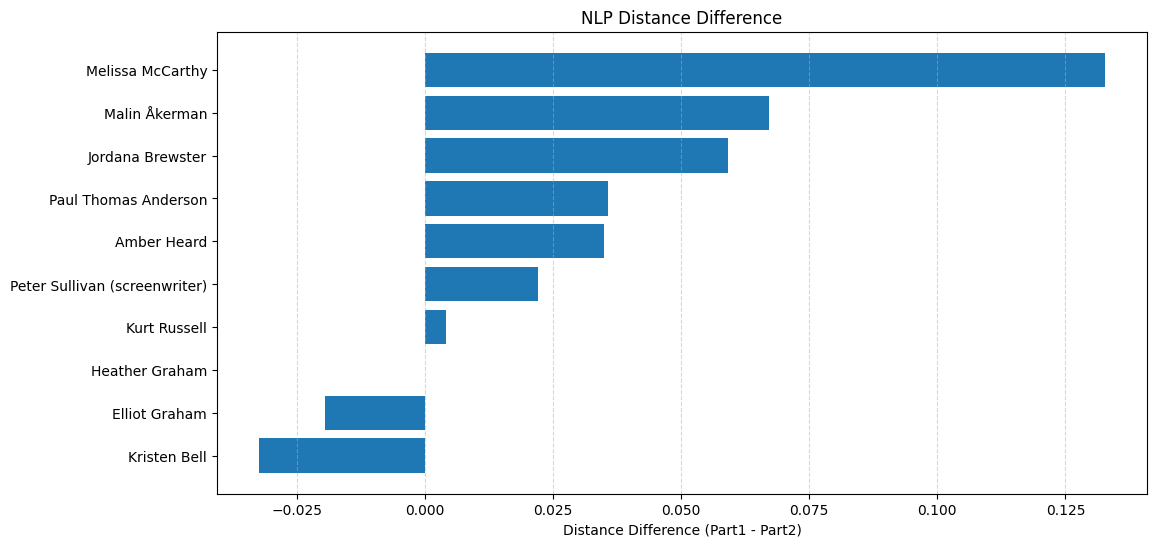

In [84]:
# PLOT IT!
plt.figure(figsize=(12, 6))
plt.barh(merged_df['name'], merged_df['diff'])
plt.xlabel('Distance Difference (Part1 - Part2)')
plt.title('NLP Distance Difference')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

#Part 3

[Part 3 Interactive Notebook](https://colab.research.google.com/drive/1j-270VkEJrJ60A_o61YlwRFnx-0esenj?usp=sharing)

Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.

In [85]:
#This was initially saved as a separate notebook, but seems better to put it all together

# Load NLP DBpedia dataset
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"
df = pd.read_csv(url)

names = df['name']

# LOAD PICKLE: Load the text blob list
with open('uberblob.p', 'rb') as file:
    uberblob = pickle.load(file)

# Create TF-IDF matrix
vectorizer = CountVectorizer(stop_words='english')
bow_matrix = vectorizer.fit_transform(uberblob)
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(bow_matrix)

# Fit NearestNeighbors model
nn_model = NearestNeighbors().fit(tfidf_matrix)

In [86]:
# Find 10 nearest neighbors
def find_neighbors(target_name):
    idx = df[df['name'] == target_name].index[0]
    row = tfidf_matrix.getrow(idx)

    distances, indices = nn_model.kneighbors(X=row, n_neighbors=10)

    nearest_df = df.iloc[indices[0]].copy()
    nearest_df['distance'] = distances[0]

    display(nearest_df[['name', 'distance', 'text']])

# Create interactive dropdown widget (thanks to ChatGPT for this dropdown)
interact(find_neighbors, target_name=Dropdown(options=sorted(names.unique()), description="Select Name"));


interactive(children=(Dropdown(description='Select Name', options=(' Renate Lorenz', '%C3%80lex Rigola', '%C3%…